# Neural Networks

### What is a neural network?


Neural networks are computer systems that try to understand patterns in data, like how our brains do. They are made up of artificial neurons that process information in layers, passing it from one layer to another. By adjusting the connections between these neurons based on examples, neural networks can learn and make predictions on new data, helping us solve problems like image recognition, language understanding, and more. Neural networks are like smart algorithms that learn from examples.

Imagine you want to teach a computer to recognize cats. You would show it lots of pictures of cats and say, "These are cats." The computer would learn to identify the patterns in the pictures that make them cats. Then, when you give it a new picture, it can tell you if it's a cat or not based on what it learned.

The cool thing is that neural networks can learn all sorts of things, not just about cats. They can learn to understand speech, translate languages, or even play games. They're powerful tools that make computers smarter and help them do all kinds of tasks that normally only humans can do.

<div>
    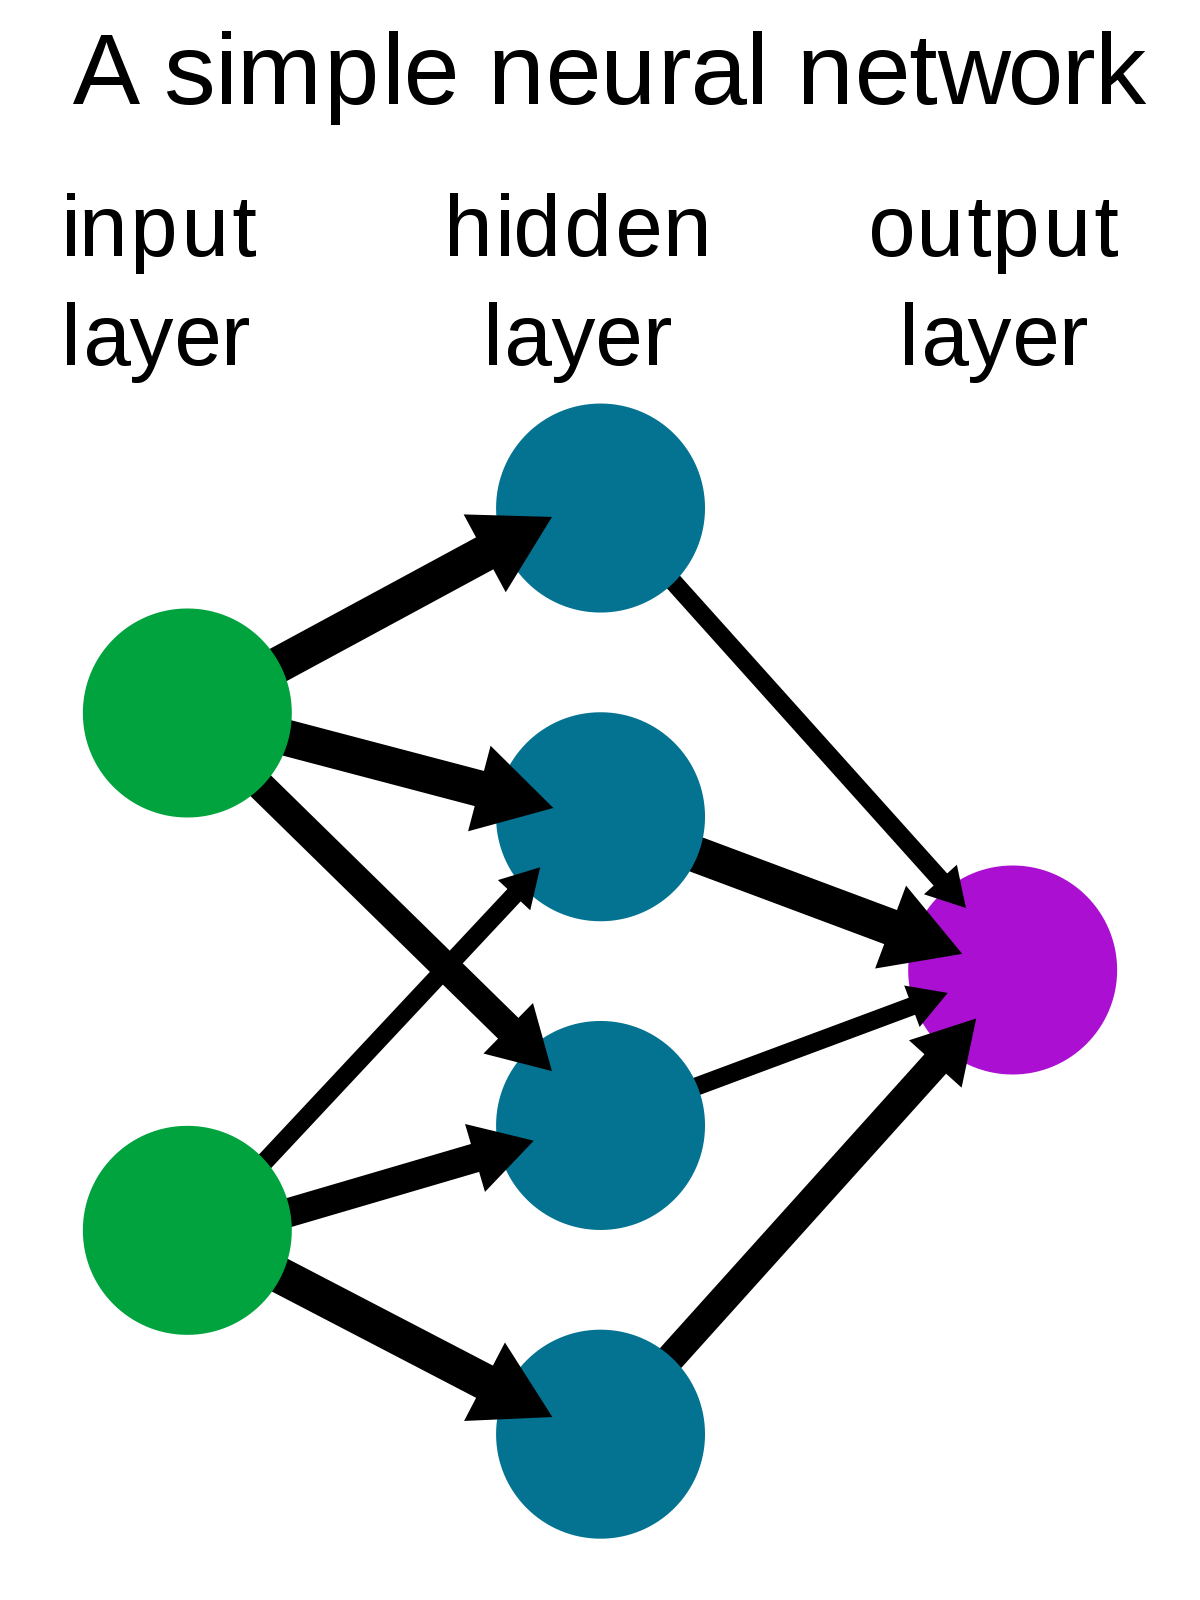
</div>

Neural networks can also have multiple layers, they don't necessarily have to be restricted to only one layer.



<div>
    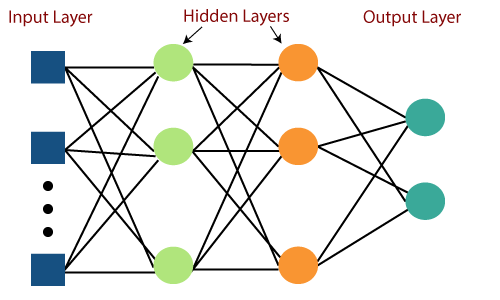
</div>



### AI, ML, Deep Learning, Neural Networks... What's the difference?

There is a lot of confusion regarding these terms, and rightfully so. The following image and explanations aim to hopefully give a clearer picture of some of the distinctions amongst these confusing terms. 



<div display="inline-block">
    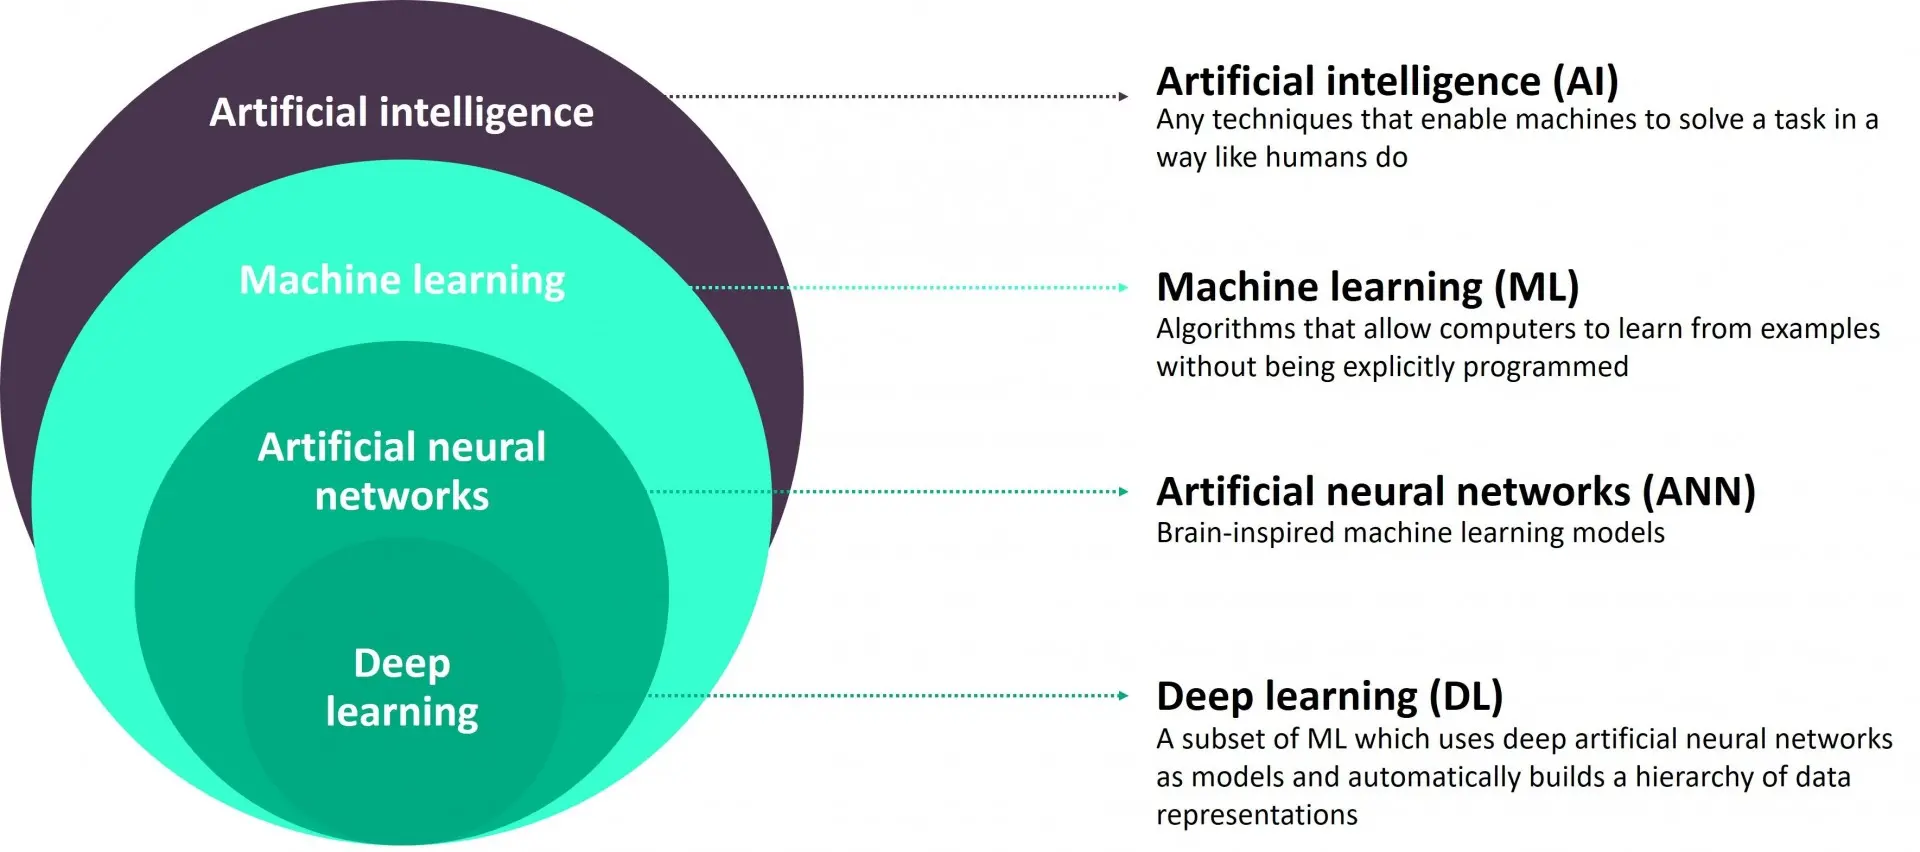
<ul>
<li>AI is the technique which enables machines to mimic human behaviour.</li>
<li>Machine learning (ML) is a subset of AI which ueses statistcial methods to enable machines to imporve, with experience.</li>
<li>Deep learning is a subset of ML which makes the computation of multi-layered neural networks feasible.</li>
</ul>

</div>


Let's load in the packages necessary for creating NNs in Python. 

In [6]:
# Load in the necessary Python libraries. We will be using pandas, numpy and matplotlib (for now). 
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
# from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor


from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

### What dataset will we be using?
We will be working with a dataset that's modeled after real existing milling machines, which falls under the domain of manufacturing.
<br></br>
A milling machine is a versatile industrial tool used to shape and machine solid materials, such as metal, wood, or plastic. It employs rotary cutters to remove material from a workpiece, creating complex shapes, holes, and patterns with high precision. Milling machines are integral to manufacturing processes, enabling the creation of precise parts for industries like automotive, aerospace, and electronics. They come in various types, including vertical and horizontal mills, each offering specific capabilities for tasks such as cutting, drilling, and contouring, making them essential for both prototyping and mass production.
<br></br>
This dataset could be useful if we wish to learn more about how machine failures are related to technical specifications such as air and process temperature, rotational speed, torque, and more.
<br></br>
If you would like to access this dataset from the source, you can find it here: https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020.

In [7]:
# Go into the data folder, and read in the csv dataset into the Python workspace. 
# Then, name that item "data".
data = pd.read_csv('../data/millingMachine.csv')
data.head() # print out only the first few rows, for easy viewing.

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Now that we have loaded our data, let's look further into some of the columns we'll be working with:

- UID: unique identifier ranging from 1 to 10000
- product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
- type: just the product type L, M or H from column 2
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
- a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.


Moreover, when it comes to machine failure, there are five independent failure types that should be noted:

1. tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
2. heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
3. power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
4. overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
5. random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

### Let's get a quick summary rundown of our machine maintenance data! This can be done using the ```.info()``` function. 

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

### What does the above summary tell us about our concrete dataset?
- There's a total of 14 columns, and 1000 rows.
- There are 3 float64 columns, 9 int64 columns, and 2 object columns.
- There are no columns with missing values

For now, we are curious with the machine failure. 

Let's use the ```value_counts()``` function to obtain statistics about the distribution of working and failing machines.

In [9]:
data['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

What if we wanted the percentage distribution of the machine failures? 

What would that look like?

In [10]:
data['Machine failure'].value_counts(normalize=True)

0    0.9661
1    0.0339
Name: Machine failure, dtype: float64

So, it appears that around 97% of machines are operational, with 3% experiencing failure. 

In [11]:
data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [12]:
data = data.iloc[:, 2:9]

data

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14,0
9996,H,298.9,308.4,1632,31.8,17,0
9997,M,299.0,308.6,1645,33.4,22,0
9998,H,299.0,308.7,1408,48.5,25,0


It appears that we have a categorical variable, ```Type```! 

We will see how to address this later. 

For now, let's split our data into training and testing sets. 

In [13]:
X = data.drop(columns=["Machine failure"])
y = data["Machine failure"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

When it comes to working with neural networks, there are two requirements. 

- All data must be numeric.
- All data should be scaled.

Let's output our X_train data for example, and see what we got. 

In [14]:
X_train

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
9254,L,298.3,309.1,1616,31.1,195
1561,L,298.2,308.4,1388,53.8,137
1670,L,298.2,307.8,1528,31.1,194
6087,M,300.9,310.8,1599,33.0,7
6669,L,301.4,310.5,1571,33.9,208
...,...,...,...,...,...,...
5734,L,302.3,311.8,1369,56.2,208
5191,L,304.0,313.2,1416,46.0,128
5390,H,302.8,312.3,1483,47.2,223
860,H,296.1,306.9,1541,32.6,33


In [15]:
numeric_features = list(X_train.iloc[:, 1:].columns.values)
categorical_features = ['Type']

numeric_features

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]']

In [16]:
categorical_features

['Type']

In [17]:
len(data['Type'].unique())

3

In [18]:
ct_machine = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features),
)


ct_machine

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['Air temperature [K]',
                                  'Process temperature [K]',
                                  'Rotational speed [rpm]', 'Torque [Nm]',
                                  'Tool wear [min]']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['Type'])])

### Preparing Our Model

Now that we have our preprocessing object (ct for column-transformer), we can put it in a pipeline with the NN we're about to create. 

In sklearn, their supervised feedforward NN offerings are known as MLP, which stands for multi-layer perceptron (it's just another name for feedforward NNs).

Since feedforward NNs are supervised, we can perform regression ```MLPRegressor``` or classification ```MLPClassifier```. 

We will be using ```MLPClassifier``` since we're simply trying to predict whether a machine will fail or not. This is a binary value, which calls for the usage of a classification model, rather than regression. 

In [19]:
neural_net = MLPClassifier(
    hidden_layer_sizes=(10,), # Single hidden layer with 10 neurons/nodes in it 
    max_iter=2000,
    learning_rate_init=0.03,
    random_state=42
    )

machine_model = make_pipeline(ct_machine, neural_net)
machine_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Type'])])),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(10,),
                               learning_rate_init=0.03, max_iter=2000,
                               random_state=42))])

Two very important parameters are the ```max_iter``` and ```learning_rate_init``` parameters. 

These two combined together can solve any potential ```ConvergenceWarning``` messages, which means that our model did not find an optimal solution to the problem. In other words, the model did not converge. 

This could be caused by too little iterations/cycles. The model was not given enough opportunities to perform the computation it needed to. An iteration is when the model is shown all training examples, and backpropagation is used to update the model for each example. The default value for ```max_iter``` is 200, so if you're getting a ```ConvergenceWarning```, 200 iterations may not be enough, and you need to increase that value. Under the hood, our model went through every single training example 200 times, and still could not find an optimal solution.  


However, you may soon find out that increasing the ```max_iter``` value is not enough to solve the problem. The issue here is that our model is actually **not learning fast enough**. 

This is where the ```learning_rate_init``` argument comes in. 
|
According to the scikit-learn documentation, the ```learning_rate_init``` parameter controls the step-size in updating the weights. Its default value is 0.001. In other words, the learning rate dictates how much the model changes each weight, for every training example it sees.

So then you might be wondering, why not just give a very large number? Well, the issue is that if the learning rate is **too** large, then there is a risk that the model might jump over the optimal value for the given weight. 

We need to find a balance where our model learns quick enough so that it converges, but not so quick that it jumps over/past the optimal value, in terms of the weights. 

If you don't know what value to use for the learning rate, try to the following pattern: 0.0001 -> 0.0003 -> 0.001 -> 0.003 -> 0.01 -> 0.03 -> 0.1 -> 0.3, and so on.

Lastly, the ```hidden_layer_sizes``` argument controls how many hidden/middle layers we wish to create. Since the input and output layers are automatically defined, we have no control over that. However, we do have control over what the middle layers look like. 

The syntax is simple, each layer are separated by columns, with a number designating the number of neurons in that particular layer. 

Sometimes it is worth to decrease the amount of hidden layers, as the tradeoff between loss of accuracy is worth it for the drastically improved training time. For example, if 100 hidden layers takes the model 30s to initiate with 93% accuracy, then 10 layers may be worth it, because it takes 5s with 92% accuracy. 

After understanding those parameters and tweaking their values within our model, we are ready to do training on it. As complicated as NNs may seem, we treat it just like any other ML model, we we use the ```fit``` function on our training data. 

Please note that the training process below may take some time, depending on how large your dataset is and how many neurons and layers were specified for the hidden layer.

Another reason why NNs take such a long time is because of the backpropagation process. 

In [20]:
machine_model.fit(X_train, y_train)

C:\Users\TESTUSER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Type'])])),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(10,),
                               learning_rate_init=0.03, max_iter=2000,
                               random_state=42))])

To get a sense of the performance of our NN, we can call the ```score``` function.

Classification models such as ```MLPClassifier``` uses accuracy as the default scoring metric. Accuracy is the number of correct predictions, divided by the number of all predictions.  

In [21]:
machine_model.score(X_test, y_test)

0.98

As you can see, our model is pretty good at predicting machine failure. 

It has an accuracy score of 98%. 

### The Loss Curve

The loss curve is a graphical representation of how the loss or error of an ML model changes over the course of training. The loss function measures the discrepancy between the predicted output of the model and the actual target values in the training data. As the model is being trained, it attempts to minimize this loss by adjusting its parameters.

Basically, the loss curve tells us the error of our model at each iteration. 

For every iteration our model takes, there is a loss value. If the loss value decreases as the number of iterations progresses, that means our model is learning.

In [22]:
loss_curve = machine_model.named_steps.mlpclassifier.loss_curve_
print(loss_curve)


[0.15636482397434875, 0.09857149597357094, 0.09330040081878369, 0.08980461552507087, 0.08990173639928643, 0.0870556812114269, 0.08283112670482208, 0.08304298394129399, 0.08329179632753816, 0.08187917257552298, 0.0833937376282992, 0.07520758555914872, 0.07406475555446222, 0.0710549124531866, 0.07286285245134458, 0.06879755063911996, 0.06639632119452908, 0.06788575268669982, 0.06404353192136678, 0.06435120041183462, 0.06883409309178237, 0.06847825853071336, 0.0646024810046479, 0.0640699132928512, 0.06327073760721179, 0.06643310953378802, 0.06269018857488116, 0.0615544325839043, 0.06443280219646327, 0.06070102547833224, 0.060596228179215145, 0.06344169746358956, 0.06086455143682997, 0.05969382388201049, 0.0649178211117655, 0.06041745071290008, 0.059939477231198225, 0.060689589457581176, 0.05972650745071225, 0.05942616308326048, 0.05933618183461026, 0.058753427228348726, 0.05968770645483936, 0.05783221508885548, 0.05956881835179197, 0.056808182321933305, 0.057175120705484465, 0.05894569221

<AxesSubplot: >

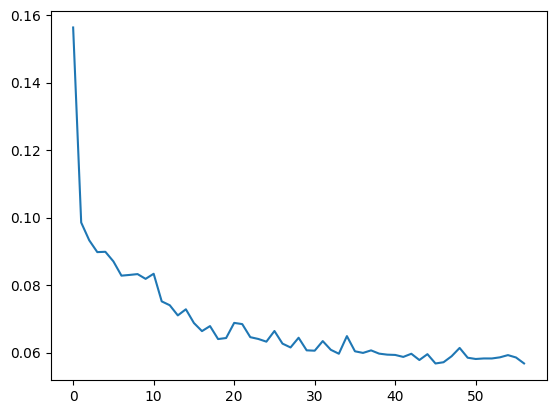

In [23]:
pd.Series(loss_curve).plot.line()

### So then how do we know when our model should stop? (In other words, how does the model determine the number of iterations it takes (in this case, 123))

Our model will know when to stop depending on configurations of the ```tol``` (tolerance) and ```n_iter_no_change``` (number of iterations without change) parameters within the MLPRegressor model. 

These numbers may be confusing at first but the functionality is quite simple: When the loss is not improving by a certain amount specified by ```tol``` for ```n_iter_no_change``` number of consecutive iterations, then convergence is considered to have been reached and the training stops. 

For example, if I had a ```tol``` value of 5 and ```n_iter_no_change``` of 10, then I would be saying for a span of 10 iterations, if the current loss value is not less than the best loss minus 5, then the model has reached convergence. In other words, for the next 10 iterations, there must be 1 iteration where the loss value is below best loss minus 5, otherwise the model stops.  